In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: 
    raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'


# Is it a bird? Creating a model from your own data

## Step 1: download images of birds and non-birds

### Step 1.1: Set up crawler
This is just some code for setting up the crawler that'll get us images from the internet.
It's not necessary for training our model so you can skip this block if you're not interested.

In [3]:
from icrawler import ImageDownloader
from icrawler.builtin import GoogleImageCrawler
from icrawler.builtin.google import GoogleFeeder, GoogleParser

class MyDownloader(ImageDownloader):
    def get_filename(self, task, default_ext):
        filename = super(MyDownloader, self).get_filename(task, default_ext)
        filename = filename.split(".")[0]
        return self.prefix + filename + ".png"

class MyCrawler(GoogleImageCrawler):
    def __init__(self, feeder_cls=GoogleFeeder, parser_cls=GoogleParser, downloader_cls=MyDownloader, prefix="", *args, **kwargs):
        super().__init__(feeder_cls, parser_cls, downloader_cls, *args, **kwargs)
        self.downloader.prefix = prefix

In [4]:
# Define a search_images function for sake of ease

def search_images(term, max_images=30, folder_name="."):
    print(f"Searching for '{term}'")
    crawler = MyCrawler(prefix=term, storage={'root_dir': folder_name},)
    crawler.crawl(keyword=term, max_num=max_images)

In [17]:

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

search_images("bird", 1, "PicturesBirds")

Searching for 'bird'


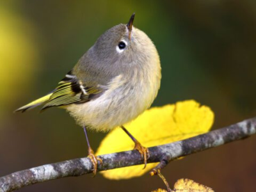

In [18]:
from fastai.vision.all import *
im = Image.open("PicturesBirds/bird000001.png")
# icrawler names the downloaded photos from 000001 to 999999
im.to_thumb(256,256)

In [7]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
search_images("forest", 1, "PicturesBirds")

Searching for 'forest'


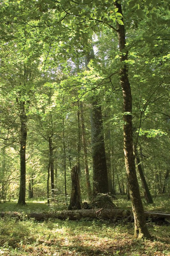

In [8]:
im = Image.open("PicturesBirds/forest000001.png")
im.to_thumb(256,256)

In [9]:
numberPhotos = 20

searches = "forest", "bird"
path = Path("Pictures")

import time

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

for o in searches:
    destination = (path/o)
    destination.mkdir(exist_ok=True, parents=True)
    search_images(f"{o} photo", numberPhotos, destination)
    time.sleep(10)  
    search_images(f"{o} sun photo", numberPhotos, destination)
    time.sleep(10)
    search_images(f"{o} night photo", numberPhotos, destination) 
    time.sleep(10)
    print(f"Photos of {o} completed!")

resize_images(path, max_size=400, dest=path, recurse=True)
print("Photo resized!")

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest night photo'
Photos of forest completed!
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird night photo'
Photos of bird completed!
Photo resized!


## Step 2: Train the model

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

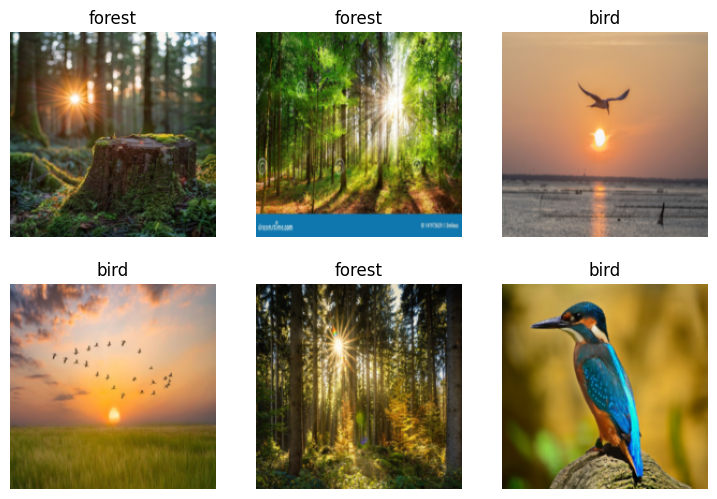

In [12]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(192, method="squish")]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.722941,1.400009,0.541667,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.719111,0.889346,0.458333,00:01
1,0.486009,0.621058,0.125000,00:01
2,0.396996,0.572445,0.125000,00:01


## Step 3: Use the model

In [16]:
isBird, _ , propability = learn.predict(PILImage.create('PicturesBirds/bird000001.png'))

print(f"This is: {isBird}")
print(f"Propability: {propability[0]:.4f}")


This is: Pictures
Propability: 0.9562
